# Метод иммитации отжига


Как уже было сказано, алгоритм Ароры хоть и позволяет решать евклидову задачу коммивояжера с приближением $1+\epsilon$ за полиномиальное время, на практике не очень эффективен и не применятся. Для её решения удобно использовать вероятностные алгоритмы, например метод иммитации отжига.

Метод иммитации отжига - алгоритм оптимизации, основанный на иммитации процесса кристалиизации вещества. Пусть в данный момент времени, атомы вещества уже выстроились в какую-то решетку. Устойчивая кристаллическая решётка соответствует минимуму энергии атомов, поэтому атом либо переходит в состояние с меньшим уровнем энергии, либо зависящая от температуры, что какие-то атомы поменяются местами. Считается, что со врменем температура уменьшается.

Более формально:
Пусть $S_i$ - состояние системы на i-ой итерации алгоритма, $t_i$ = температура на данной итерации, $F$ - недетерменированная функция перехода, $E(S_i)$ - энергия системы на i-ой итерации. Тогда $S_c = F(S_i)$ - новое состояние. Если  $E(S_c) <= E(S_i)$, то переход происходит и $S_{i+1} = S_c$. Если же $E(S_c) > E(S_i)$, переход происходит с веротяностью с вероятностю $P = exp((E(S_i) - E(S_c))/t_i)$. На каждой итерации температура уменьшается согласно какой-то заранее заданной функции T, $t_{i+1} = T(t_i)$. Когда $t$ достигает заданного минимума, алгоритм завершается.

В Евклидовой Задаче Коммивояжера удобно в качестве состояния использоваться путь, проходящий через все вершины, в качестве энергии - его длину, а в качестве функции перехода - случаный swap двух точек на этом пути. Температура пусть уменьшается линейно.


In [1]:
from math import exp
import matplotlib.pyplot as plt
from random import uniform, randint
from itertools import permutations

%matplotlib inline

# Подготовка

Для начала сделаем небольшую подгтовку, чтобы затем проще было решать поставленную задачу.

Заведём класс для точки

In [46]:
class RandomPoint:
    def __init__(self, x_lim, y_lim):
        self.x = uniform(*x_lim)
        self.y = uniform(*y_lim)

    @staticmethod
    def distance(self, other):
        return ((self.x - other.x)**2 + (self.y - other.y)**2)**0.5


In [62]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    @staticmethod
    def distance(self, other):
        return ((self.x - other.x)**2 + (self.y - other.y)**2)**0.5



И класс для пути. Удобно будет отождествлять путь и просто упорядоченный набор точек.

In [47]:
class Path:
    def __init__(self, size=8, x_lim=(10, 20), y_lim=(10, 20), array=None):
        '''
        Если file и array не указаны, будет сгенерирован случайный набор размера size, иначе они будут прочитаны
        из файла или массива.
        '''
        if array:
            self.points = array
            self.size = len(array)
        else:
            self.points = [RandomPoint(x_lim, y_lim) for _ in range(size)]
            self.size = size

    def length(self):
        '''
        Длина текущего пути
        '''
        result = 0
        for i in range(self.size):
            result += RandomPoint.distance(self.points[i], self.points[(i + 1) % self.size])
        return result

    def draw(self, only_points=True, with_len=False):
        '''
        Функция, которая рисует текущий путь. Можно только точки, или соеденить их.
        '''
        x = [point.x for point in self.points]
        y = [point.y for point in self.points]
        plt.figure(figsize=(15, 7))
        plt.scatter(x, y, label="Points", color="black")
        if not only_points:
            plt.plot(x + [x[0]], y + [y[0]], label="points", color="green")
        if with_len:
            plt.title("Length = {}".format(self.length()))

        plt.legend()
        plt.show()

    def swap(self, i, j):
        '''
        Меняет i и j точки в пути местами. Полезно для функции перехода.
        '''
        self.points[i], self.points[j] = self.points[j], self.points[i]

# Алгоритм 
Перейдем к реализации самого алгоритма

In [48]:
class SimulatedAnnealing:
    def __init__(self, start_state, t_start, t_min, t_change, energy, transition, limit):
        '''
        Потребуем, чтобы функция перехода возвращала функцию, применив которую, мы бы могли вернуться в 
        предыдущее состояние. Это позволит нам не копировать массивы.
        '''
        self.start_state = start_state  # начальное состояние
        self.t_start = t_start          # начальная температура
        self.t_min = t_min              # минимальная температура
        self.t_change = t_change        # функция изменения температуры
        self.energy = energy            # функция энергии
        self.transition = transition    # функция перехода в новое состояние
        self.limit = limit              # ограничение на количество итераций
    def calculate(self):
        step = 1
        current_t = self.t_start
        state = self.start_state
        current_energy = self.energy(self.start_state)
        while current_t > self.t_min and step < self.limit:
            transition_reverse = self.transition(state)  # переходим в новое сотояние
            new_energy = self.energy(state)
            d_energy = new_energy - current_energy
            if d_energy < 0 or (d_energy > 0 and exp(-d_energy/current_t) > uniform(0, 1)):  # смотрим, могли ли мы
                current_energy = new_energy                                                  # сделать этот переход
            else:  #  если не могли, то откатываемся назад
                transition_reverse(state)
            current_t = self.t_change(self.t_start, step)
            step += 1

        return state

In [49]:
def energy(path):
    return path.length()


def t_change(t_start, step):
    return t_start/step


def transition(path):
    n = path.size
    i, j = randint(0, n - 1), randint(0, n - 1)
    path.swap(i, j)

    return lambda p: p.swap(i, j)

Конечно, для оценки эффективность метода нам потребуется способ узнать правильный ответ. Для этого мы просто переберем все возможные пути.

In [50]:
def find_best_path(points):
    result = points
    min_len = points.length()
    for permutation in permutations(points.points):
        new_path = Path(array=permutation)
        if new_path.length() < min_len:
            min_len = new_path.length()
            result = new_path

    return result


Убедимся, что наш алгоритм работает. Сгенерируем 10 точек и запустим его.

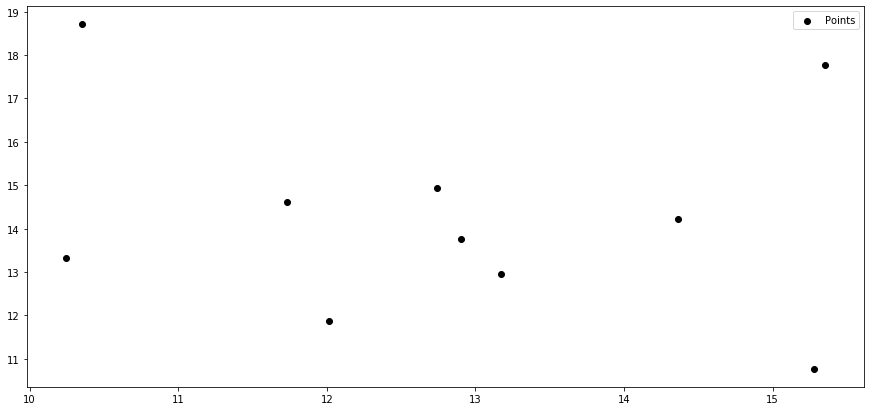

In [51]:
points = Path(size=10)
points.draw()

Запустим алгоритм иммитации отжига

In [52]:
%%time
sa = SimulatedAnnealing(start_state=points,
                            t_start=10,
                            t_min=0.00001,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=1000)
sa_path = sa.calculate()

CPU times: user 16.6 ms, sys: 482 µs, total: 17.1 ms
Wall time: 17.6 ms


In [53]:
%%time
best_path = find_best_path(points)

CPU times: user 30.1 s, sys: 122 ms, total: 30.2 s
Wall time: 30.5 s


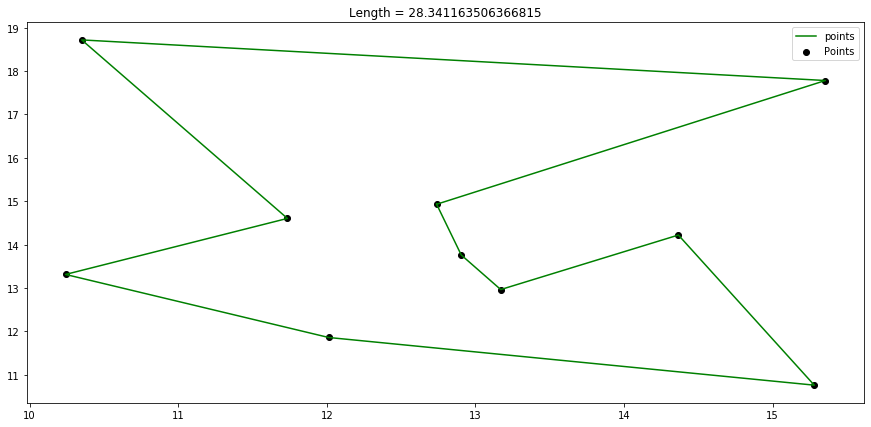

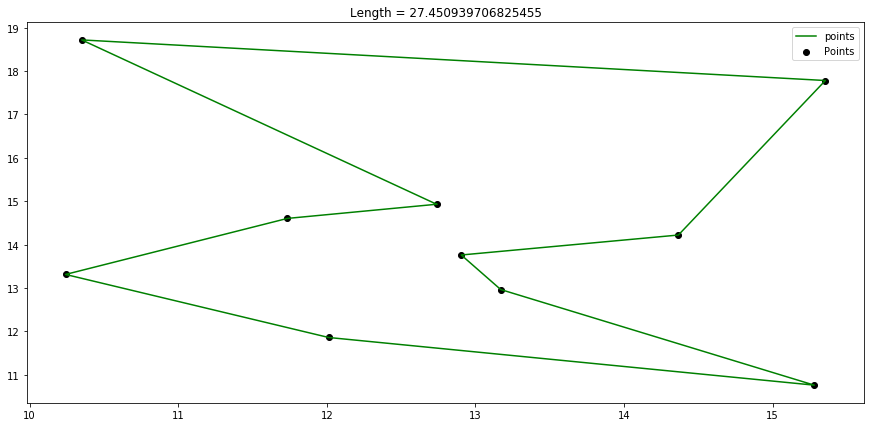

In [56]:
sa_path.draw(only_points=False, with_len=True)
best_path.draw(only_points=False, with_len=True)

Замечательно, наш алгоритм добился почти идеального решения, при этом потратил на это гораздо меньше времени.

Попробуем оценить среднее приближение нашего алгоритма на 8 точках.

In [58]:
result = 0
for _ in range(1000):
    points = Path()
    sa = SimulatedAnnealing(start_state=points,
                            t_start=10,
                            t_min=0.0001,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=1000)
    sa_path = sa.calculate()
    best_path = find_best_path(points)
    result += sa_path.length()/best_path.length()

print("Среднее отношение длины найденного пути к минимальной длине: ", result/1000)

Среднее отношение длины найденного пути к минимальной длине:  1.0671335351555191


Теперь попробуем запустить алгоритм на более крупных данных. Следующий датасет содержит 131 точку. Оптимальный путь имеет длину 564. Попробуем добиться точности не хуже 1.25.

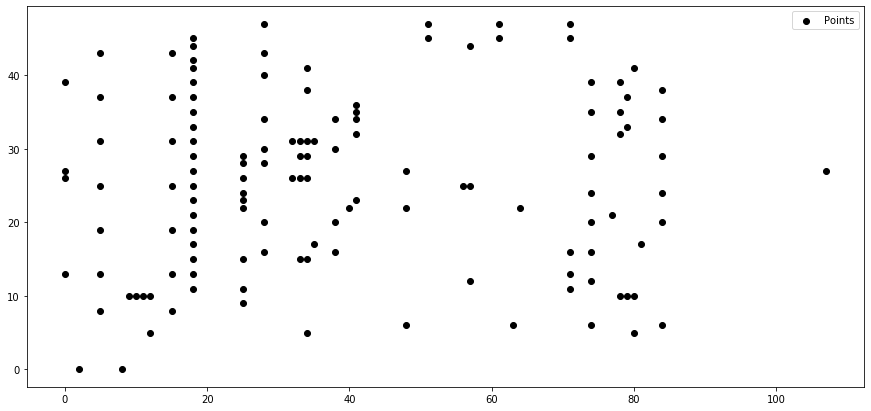

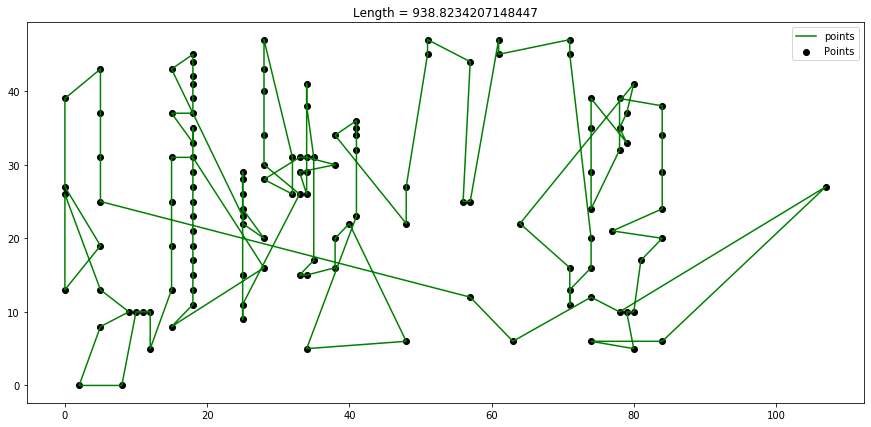

In [168]:


f = open('bigtest.txt')
points = []
for line in f:
    line = line.split()
    points.append(Point(float(line[1]), float(line[2])))
    
many_points = Path(array=points)
many_points.draw()


sa = SimulatedAnnealing(start_state=many_points,
                            t_start=10,
                            t_min=0.0001,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=10000)


sa_path = sa.calculate()
sa_path.draw(only_points=False, with_len=True)

Получилось быстро, но не очень оптимально. Хотя приближение и лучше 2. Попробуем изменить начальные значения температуры и функцию её изменения, а также увеличить лимит итераций.

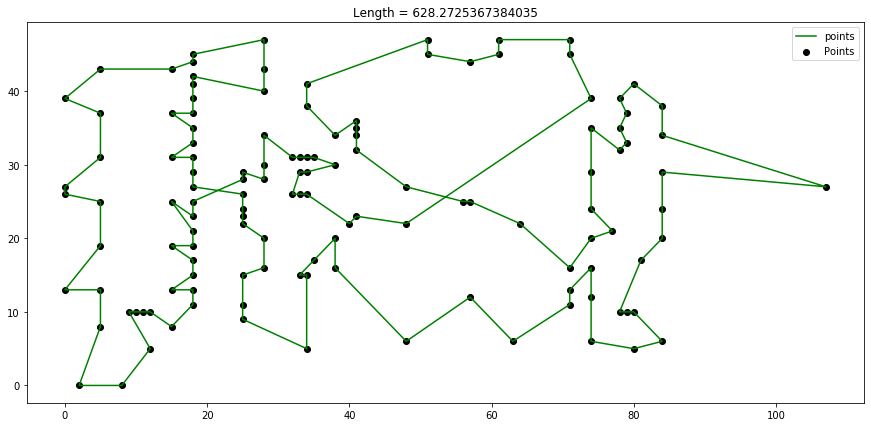

In [180]:
from math import log

def t_change(t_start, step):
    return t_start/step**0.4


sa = SimulatedAnnealing(start_state=many_points,
                            t_start=300,
                            t_min=0,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=10000000)


sa_path = sa.calculate()
sa_path.draw(only_points=False, with_len=True)

Нам за разумное время удалось достигнуть точности лучше, чем 1.12. Вот так должен выглдяеть правильный маршрут. Довольно похоже.

![title](xqf131.tour.gif) 

Попробуем запустить наш алгоритм на реальных данных. В качестве примера возьмем координаты городов Зимбабве.

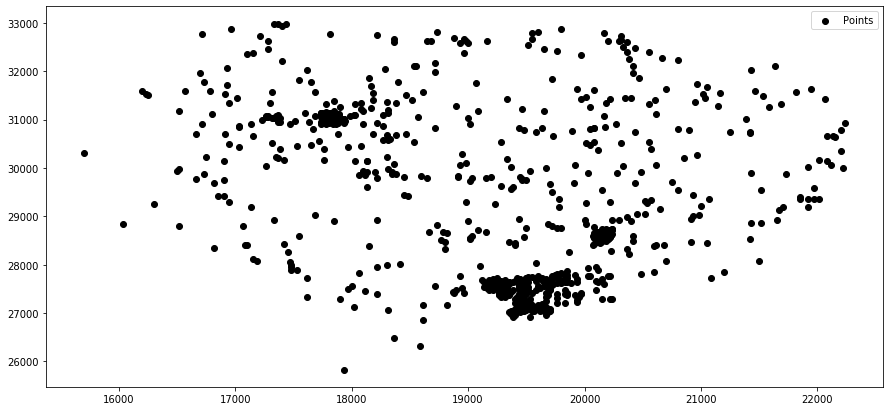

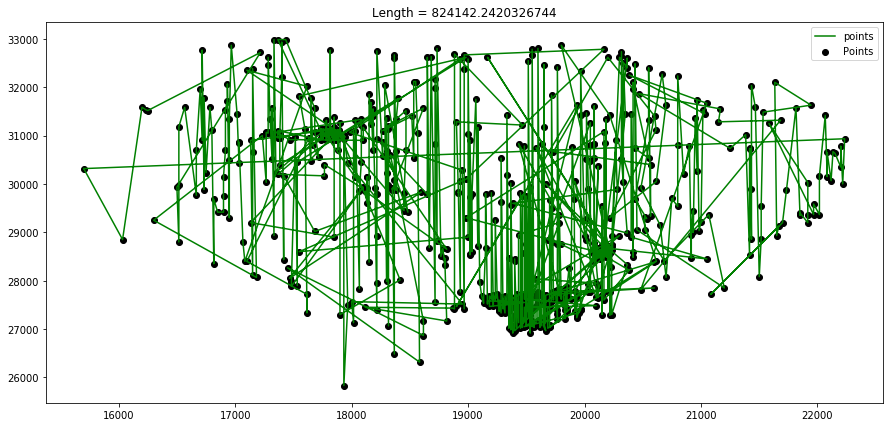

In [181]:
f = open('Zimbabve.txt')
points = []
for line in f:
    line = line.split()
    points.append(Point(float(line[1]), float(line[2])))
    
zimbabve = Path(array=points)
zimbabve.draw()

def t_change(t_start, step): # возвращаем прежнее значение функции изменения температуры
    return t_start/step

sa = SimulatedAnnealing(start_state=zimbabve,
                            t_start=10,
                            t_min=0.0001,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=1000)


sa_path = sa.calculate()
sa_path.draw(only_points=False, with_len=True)


Видим, что у полученного пути много самопересечений, у оптимального пути их быть не должно. Попробуем увеличить начальную температуру и лимит на количество итераций.

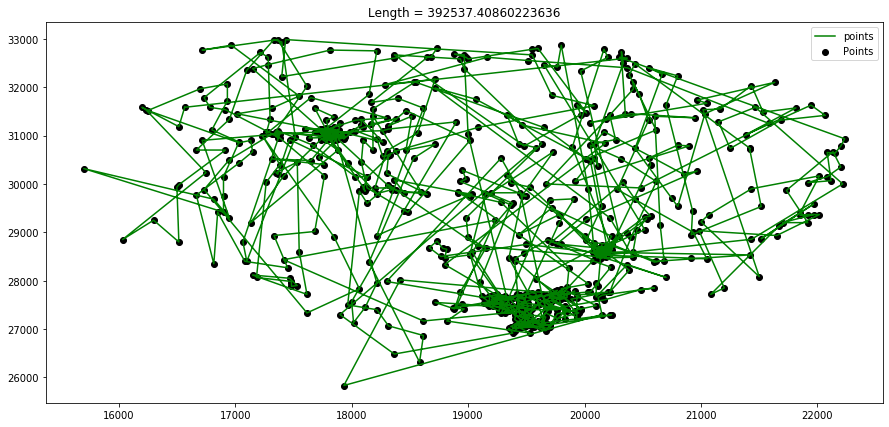

In [75]:
%%time
sa = SimulatedAnnealing(start_state=zimbabve,
                            t_start=1000,
                            t_min=0.0001,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=100000)


sa_path = sa.calculate()
sa_path.draw(only_points=False, with_len=True)

Видим, что алгоритм стал работать дольше, но количество самопересечений значительно уменьшилось. Попробуем еще увеличить параметры.

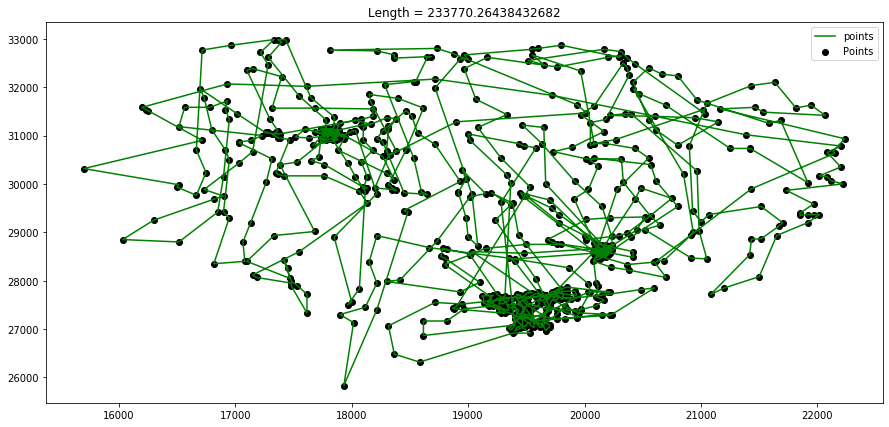

CPU times: user 11min 40s, sys: 5.54 s, total: 11min 45s
Wall time: 12min 6s


In [77]:
%%time
sa = SimulatedAnnealing(start_state=zimbabve,
                            t_start=1000,
                            t_min=0.000001,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=1000000)


sa_path = sa.calculate()
sa_path.draw(only_points=False, with_len=True)

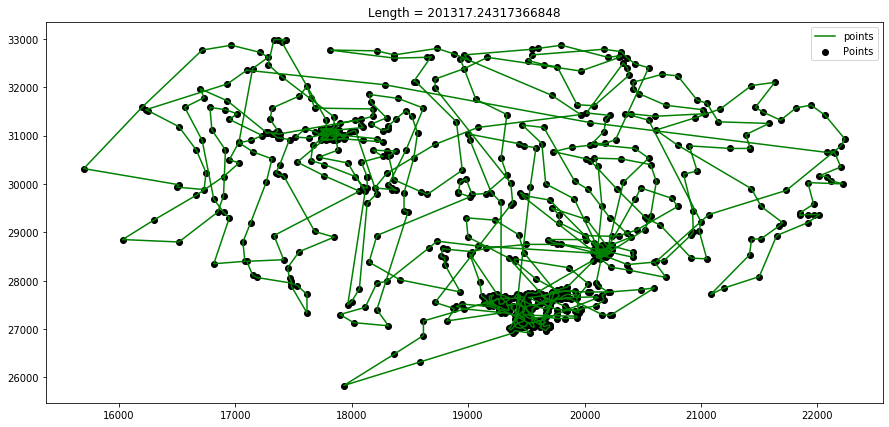

CPU times: user 1h 52min 21s, sys: 11.6 s, total: 1h 52min 33s
Wall time: 7h 49min 25s


In [78]:
%%time
sa = SimulatedAnnealing(start_state=zimbabve,
                            t_start=5000,
                            t_min=0.0000002,
                            t_change=t_change,
                            energy=energy,
                            transition=transition,
                            limit=10000000)


sa_path = sa.calculate()
sa_path.draw(only_points=False, with_len=True)

Видно, при аккуратно подобранных параметрах и достаточном ограничении на количество итераций наш алгоритм дает приемлимый результат.